In [1]:
from sage import EBSD

In [2]:
ebsdfile = EBSD("EBSD.ctf")
df = ebsdfile.get_ebsd_data()

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from joblib import Parallel, delayed

chunk_size = 10000

def process_chunk(chunk):
    X = chunk[['Euler1', 'Euler2', 'Euler3']]
    y = chunk['Phase']
    
    # Filter Phase 0 for training the classifier
    X_train = X[y != 0]
    y_train = y[y != 0]
    
    # Train K-nearest neighbors classifier
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    
    # Predict Phase for Phase 0 pixels
    X_test = X[y == 0]
    phase_0_predictions = knn_model.predict(X_test)
    
    chunk.loc[chunk['Phase'] == 0, 'Phase'] = phase_0_predictions
    
    return chunk

num_chunks = int(np.ceil(len(df) / chunk_size))
df_chunks = np.array_split(df, num_chunks)

# Process each chunk in parallel
num_cores = 4  # Adjust according to the available CPU cores
processed_chunks = Parallel(n_jobs=num_cores)(delayed(process_chunk)(chunk) for chunk in df_chunks)

df_processed = pd.concat(processed_chunks)

df_processed.to_csv("classified_dataset.csv", index=False)


/Users/usin8611/anaconda3/envs/pygmt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


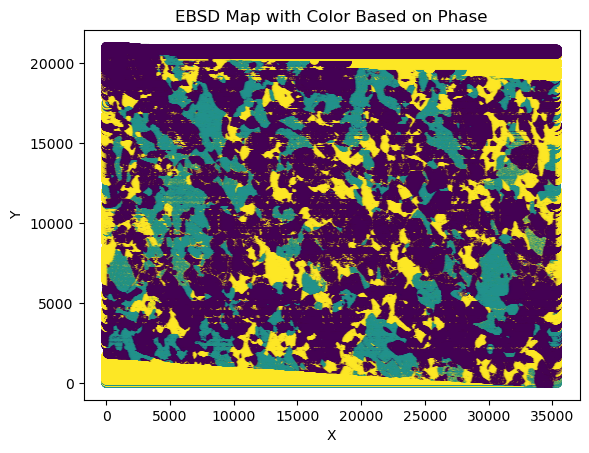

In [4]:
import matplotlib.pyplot as plt
data = df_processed
df_new = data[data['Phase'].isin([0, 1, 2, 3])]
plt.scatter(df_new['X'], df_new['Y'], c=df_new['Phase'], cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('EBSD Map with Color Based on Phase')
# plt.colorbar(label='Phase')
plt.show()

# Convex Hull

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Read the data
data = df

# Filter data for phases greater than 0
filtered_data = data[data['Phase'] > 0]

# Extract x and y values
x_values = filtered_data['X']
y_values = filtered_data['Y']

# Create a polygon from the filtered points
polygon = Polygon(zip(x_values, y_values))

# Get the bounding rectangle of the polygon
min_x, min_y, max_x, max_y = polygon.bounds

# Plot the original data
plt.scatter(data['X'], data['Y'], c=data['Phase'], cmap='viridis')

# Plot the bounding rectangle
plt.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y], color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bounding Rectangle for Phases > 0')
plt.colorbar(label='Phase')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Read the data
data = df

# Filter data for phases greater than 0
filtered_data = data[data['Phase'] > 0]

# Extract x and y values
points = filtered_data[['X', 'Y']].values

# Compute convex hull
hull = ConvexHull(points)

# Plot the original data
plt.scatter(data['X'], data['Y'], c=data['Phase'], cmap='viridis')

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Convex Hull for Phases > 0')
plt.colorbar(label='Phase')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Read the data
data = df

# Filter data for phases greater than 0
filtered_data = data[data['Phase'] > 0]

# Extract x and y values
points = filtered_data[['X', 'Y']].values

# Compute convex hull
hull = ConvexHull(points)

# Plot the original data
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(data['X'], data['Y'], c=data['Phase'], cmap='viridis')

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Convex Hull for Phases > 0')
plt.colorbar(label='Phase')
plt.grid(True)

# Save the plot as a PDF with high resolution
plt.savefig("convex_hull_plot.pdf", dpi=300)  # Adjust dpi for higher resolution
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

data = df

filtered_data = data[data['Phase'] > 0]

# Extract x and y values
points = filtered_data[['X', 'Y']].values

hull = ConvexHull(points)

points_within_hull = points[hull.vertices]
indices_within_hull = filtered_data.index.isin(filtered_data.index[hull.vertices])
data_within_hull = filtered_data[indices_within_hull]

X = data_within_hull[['X', 'Y', 'Bands', 'Error', 'Euler1', 'Euler2', 'Euler3', 'MAD', 'BC', 'BS']]
y = data_within_hull['Phase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # 8 phases
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

phase_zero_data = data[data['Phase'] == 0][['X', 'Y', 'Bands', 'Error', 'Euler1', 'Euler2', 'Euler3', 'MAD', 'BC', 'BS']]
phase_zero_data_scaled = scaler.transform(phase_zero_data)
phase_zero_predictions = model.predict_classes(phase_zero_data_scaled)

data.loc[data['Phase'] == 0, 'Phase'] = phase_zero_predictions

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data, header_data = ebsdfile.ctf.get_data()
# Calculate misfit angles
data['misfit_euler1'] = abs(data['Euler1'] - 360)
data['misfit_euler2'] = abs(data['Euler2'] - 180)
data['misfit_euler3'] = abs(data['Euler3'])

# features (X) and target variable (y)
X = data[['Euler1', 'Euler2', 'Euler3', 'misfit_euler1', 'misfit_euler2', 'misfit_euler3']]
y = data['Phase']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifier (Random Forest)
clf = RandomForestClassifier()

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', clf)
])

# Train classifier
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluating classifier
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.feature_selection import SelectFromModel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data, header_data = ebsdfile.ctf.get_data()
# Calculate misfit angles
data['misfit_euler1'] = abs(data['Euler1'] - 360)
data['misfit_euler2'] = abs(data['Euler2'] - 180)
data['misfit_euler3'] = abs(data['Euler3'])

# features (X) and target variable (y)
X = data[['Euler1', 'Euler2', 'Euler3', 'misfit_euler1', 'misfit_euler2', 'misfit_euler3']]
y = data['Phase']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifier (Random Forest)
clf = RandomForestClassifier()

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', clf)
])
# Define Random Forest classifier
# clf = RandomForestClassifier()

# get feature importances
clf.fit(X_train, y_train)

sfm = SelectFromModel(clf, threshold=0.01) 
sfm.fit(X_train, y_train)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Train classifier
pipeline.fit(X_train_selected, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test_selected)

# Evaluating classifier
print(classification_report(y_test, y_pred))
